### Лабораторная работа 3. Ансамбли, отбор признаков

### Импротирование всего

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline

import warnings
warnings.filterwarnings("ignore")

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков Jupyter (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам —  проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы

* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировками
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

## Введение

Обратившись к Питеру Флаху, перечислим еще раз три ингридиента машинного обучения: задачи, модели и признаки.

Наш курс вводный, и темы извлечения признаков затрагивает очень неглубоко (на ум приходят модели мешка слов или использование дерева решений, как генератора категориального признака "номер листа"). 

На вводной лекции Саша Крайнов рассказывал вам о том, что в задачах машинного зрения применяется подход, когда одна нейронная сеть обучает и "извлекатель признаков" (на жаргоне -- тушка) и классификатор поверх данного слоя признаков (на жаргоне -- голову). 
В данной лабораторной работе (и сопряженным с ней конкурсе) мы возьмём предобученную нейронную сеть, входящую в набор моделей torchvision.models, и оставим от нее только "тушку". Таким образом у нас будет генератор признаков.

Мы сгенерировали для вас dataset с извлечёнными из картинок признаками.

Как вы понимаете, нет никаких гарантий, что данный набор признаков будет полезен для нашей задачи.

А значит, вы сможете:
  * применить методы отбора признаков 
  * обучить на лучших подмножествах модели, которые вы еще не испытвали в лабораторных
    * модели на основе растояний
    * деревья решений
    * ансамбли над деревьями решений.
  * отобрать лучшие модели
  
И получить таким образом хорошее baseline решение для конкурса.

## Задача и Dataset

Данные о задаче доступны в соревновании https://www.kaggle.com/t/c5b18ffd89ec43aa95477548b54f0e7e

Метрика -- AUC ROC

Загружаем данные, сплитим и нормируем

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('train.csv')
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
scaler = StandardScaler()
X_train[:] = scaler.fit_transform(X_train)
X_test[:] = scaler.transform(X_test)
X.shape

(4161, 512)

**Задание 1** (2.0 балл)
Оцените признаки до моделирования тяжелыми моделями.
  * Оцените связь между целевой меткой и значением признкак при помощи статистических тестов, воспользщовавшись разделом [Univariate feature selection из skalern](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)
  * Отранжируйте признаки при помощи линейного классификатора с l1-регуляризацией (например, воспользовавшись [l1-based-feature-selection из sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection))


Тестировать будем на логистической регрессии

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def cvs(model, X, y):
    return cross_val_score(model, X, y, scoring='roc_auc', n_jobs=-1).mean()

cvs(LogisticRegression(), X, y)

0.7906115728919147

Отбор признаков при помощи статистических тестов

In [49]:
from sklearn.feature_selection import f_classif, chi2, SelectKBest

for selector in [f_classif, chi2]:
    print(f'---Selector: {selector.__name__}---')
    for l in [100, 200, 300, 400]:
        X_new = SelectKBest(selector, k=l).fit_transform(X, y)
        model = LogisticRegression()
        roc_auc = cvs(model, X_new, y)
        print(f"{l} parameters: roc_auc = {roc_auc}")

---Selector: f_classif---
100 parameters: roc_auc = 0.7930824858208002
200 parameters: roc_auc = 0.8105686622014856
300 parameters: roc_auc = 0.8066127230148938
400 parameters: roc_auc = 0.7996342192126387
---Selector: chi2---
100 parameters: roc_auc = 0.7906019696656235
200 parameters: roc_auc = 0.8086784167407466
300 parameters: roc_auc = 0.8055588114545256
400 parameters: roc_auc = 0.7997797930205774


Отбор признаков при помощи LinearSVC c l1 регуляризацией

In [43]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=1, penalty='l1', dual=False, max_iter=5000).fit(X, y)
selector = SelectFromModel(lsvc, prefit=True)
X_new = selector.transform(X)
model = LogisticRegression()
roc_auc = cvs(model, X_new, y)
print(f"roc_auc = {roc_auc}")
print("X_new shape: ", X_new.shape)

roc_auc = 0.8078757084070393
X_new shape:  (4161, 401)


Во всех случаях получается лучший roc_auc при меньших признаках

**Задание 2** (0.5 балл)
    Попробуйте снизить размерность базовго набора признаков при помощи PCA.
    Визуализируйте первые 2 главные компоненты, раскрасив примеры меткой класса

Перед применением PCA нужно отнормировать данные и посмотреть, не ли выбросов и мультиколлиреарности

In [17]:
X[:] = StandardScaler().fit_transform(X)

In [18]:
X.hist(bins=50, figsize=(30, 660), layout=(110, 5));

Выбросов нет, проверим на мультиколлинеарность. Посмотрим, у сколько получится корреляций Пирсона больше 0.9.
На диагонали единицы, поэтому вычитаем единичную матрицу

In [25]:
import scipy as sp

np.count_nonzero(sp.stats.spearmanr(X).correlation - np.eye(X.shape[1]) > 0.90)

0

Мультиколлинеарности нет :)

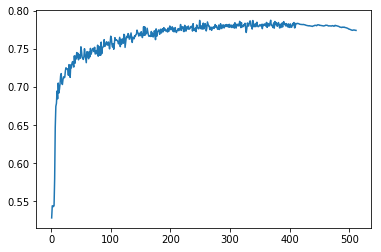

In [28]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

roc_auc_hist=[]
for n in range(X.shape[1]):
    X_new = PCA(n_components=n).fit_transform(X)
    roc_auc_hist.append(cvs(LogisticRegression(), X_new, y))
plt.plot(roc_auc_hist)

После ~250 фичей особых улучшений нет

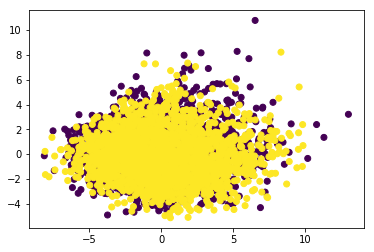

In [34]:
X_new = PCA(n_components=2).fit_transform(X)
plt.scatter(X_new[:,0], X_new[:,1], c=y)

Ну такое

Из [учебника](https://ysda_trove.gitlab.io/ml-handbook/chapters/hyperparameters_tuning/intro) вы узнали о библиотеках подбора параметров hyperopt и optuna.
Попробуйте применить любую из них в следующем блоке заданий.

Возможно, вы захотите воспользоваться реализацией [Sequential Feature Selection из sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection) для реализации отбора признаков, методом добавления.

**Задание 3** (2 балл)

    Проведите отбор признаков, методом добавления, обучая KNN-классификатор.
    
    Подберите лучшие параметры на отобранных признаках.
    
    Проведите перестановочную оценку влияния отобранных признаков


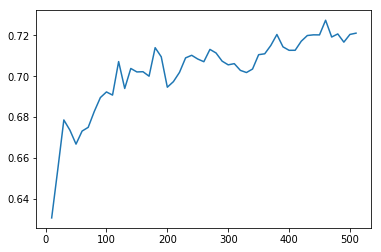

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

f_features = np.argsort(f_classif(X, y)[1])
score_hist = []
for feat_num in np.arange(10, 512, 10):
    knn = KNeighborsClassifier(n_neighbors=10)
    score_hist.append(cvs(knn, X.iloc[:, f_features[:feat_num]], y))
plt.plot(np.arange(10, 512, 10), score_hist)

После 200 признаков прирост небольшой

In [66]:
X_new = X.iloc[:, f_features[:200]]

In [80]:
from hyperopt import fmin, tpe, hp
def func(n):
    knn = KNeighborsClassifier(n_neighbors=int(n))
    return -cvs(knn, X_new, y)
    
fmin(fn=func, space=hp.uniform('x', 1, 20), algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [01:05<00:00,  1.52trial/s, best loss: -0.7224110680822455]


{'x': 19.28313054628999}

In [83]:
knn = KNeighborsClassifier(n_neighbors=19)

In [84]:
knn.fit(X_new, y)

KNeighborsClassifier(n_neighbors=19)

In [85]:
importance = permutation_importance(knn, X_new, y, n_jobs=-1)

Text(0,0.5,'Importance')

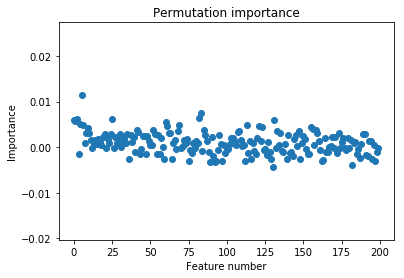

In [89]:
plt.scatter(np.arange(200), importance.importances_mean)
plt.title('Permutation importance')
plt.xlabel('Feature number')
plt.ylabel('Importance')

В данном случае распределение важности кажется почти равномерным, с едва заметным наклоном

**Задание 4** (2 балл)
    Проведите отбор признаков, методом добавления, обучая решающее дерево классификации.
    
    Подберите лучшие параметры на отобранных признаках.
    
    Проведите перестановочную оценку влияния отобранных признаков


Text(0,0.5,'Score')

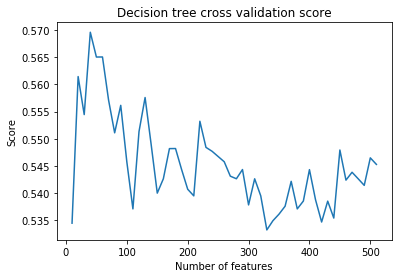

In [90]:
from sklearn.tree import DecisionTreeClassifier

score_hist = []
for feat_num in np.arange(10, 512, 10):
    tree = DecisionTreeClassifier()
    score_hist.append(cvs(tree, X.iloc[:, f_features[:feat_num]], y))
plt.plot(np.arange(10, 512, 10), score_hist)
plt.title('Decision tree cross validation score')
plt.xlabel('Number of features')
plt.ylabel('Score')

Score с самого начала так себе и убывает, возьмём 80 фичей

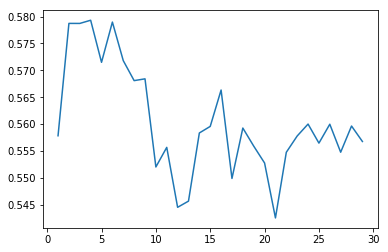

In [104]:
X_train_new = X_train.iloc[:, f_features[:80]]
X_test_new = X_test.iloc[:, f_features[:80]]

hist = []
for d in np.arange(30):
    classificator = DecisionTreeClassifier(max_depth=d)
    hist.append(cvs(classificator, X_train_new, y_train))
plt.plot(hist)

In [105]:
classificator = DecisionTreeClassifier(max_depth=4)
classificator.fit(X_train_new, y_train)

DecisionTreeClassifier(max_depth=4)

Text(0,0.5,'Importance')

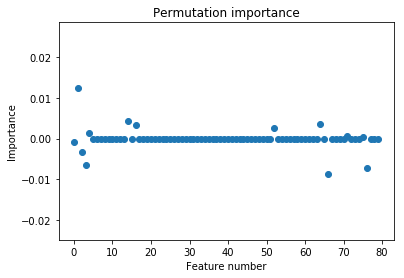

In [106]:
importance = permutation_importance(classificator, X_test_new, y_test, n_jobs=-1)
plt.scatter(np.arange(80), importance.importances_mean)
plt.title('Permutation importance')
plt.xlabel('Feature number')
plt.ylabel('Importance')

...Наверное можно сказать, что тоже чуть убывает?

**Задание 5** (2 балл)
    Подберите лучшие параметры для 
    
    Проведите отбор признаков, методом добавления, обучая классифкатор RandomForest .
    
    Подберите лучшие параметры на отобранных признаках.
    
    Проведите перестановочную оценку влияния отобранных признаков
    

Text(0,0.5,'Score')

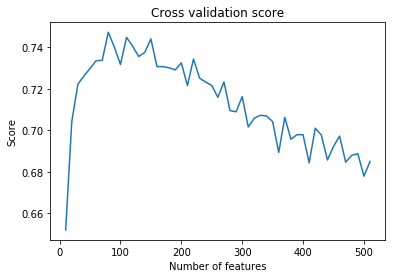

In [107]:
from sklearn.ensemble import RandomForestClassifier

score_hist = []
for feat_num in np.arange(10, 512, 10):
    classifier = RandomForestClassifier()
    score_hist.append(cvs(classifier, X.iloc[:, f_features[:feat_num]], y))
plt.plot(np.arange(10, 512, 10), score_hist)
plt.title('Cross validation score')
plt.xlabel('Number of features')
plt.ylabel('Score')

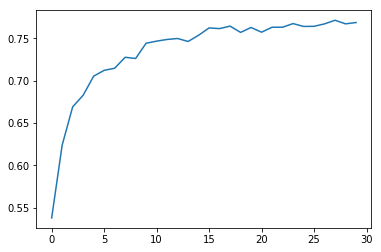

In [112]:
X_train_new = X_train.iloc[:, f_features[:100]]
X_test_new = X_test.iloc[:, f_features[:100]]

hist = []
for n in np.arange(1, 300, 10):
    print(n, end='\r')
    classificator = RandomForestClassifier(n_estimators=n)
    hist.append(cvs(classificator, X_train_new, y_train))
plt.plot(hist)

Text(0,0.5,'Importance')

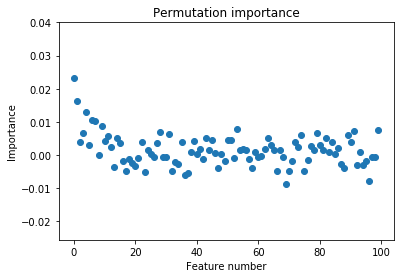

In [113]:
classificator = RandomForestClassifier(n_estimators=150)
classificator.fit(X_train_new, y_train)

importance = permutation_importance(classificator, X_test_new, y_test, n_jobs=-1)
plt.scatter(np.arange(100), importance.importances_mean)
plt.title('Permutation importance')
plt.xlabel('Feature number')
plt.ylabel('Importance')

Важность убывает

**Задание 6** (1.5 балл)
    При помощи библиотеки shap, отранжируйте признаки по степени их влияния для предсказаний модели из предыдущего пункта.
    Сопадает ли ранжирование по shap с ранжированием на основе перестановочных оценок? 

    Обучите классификатор RandomForest на всех признаках
    
    Попробуйте выкинуть хвост из "не влияющих" признаков.
    
    Что произойдет с качеством?
    
    Как пересекаются множества "выкинутых" факторов и факторов, которые не были добавлены в прошлом задании?
    
    

In [123]:
import shap
shap.initjs()

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
explainer = shap.Explainer(forest)

In [119]:
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)


In [120]:
shap_values_test = explainer.shap_values(X_test)

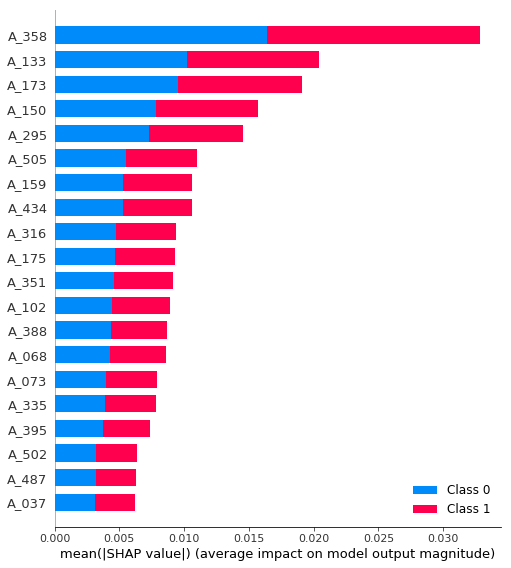

In [124]:
shap.summary_plot(shap_values_train, X_train)

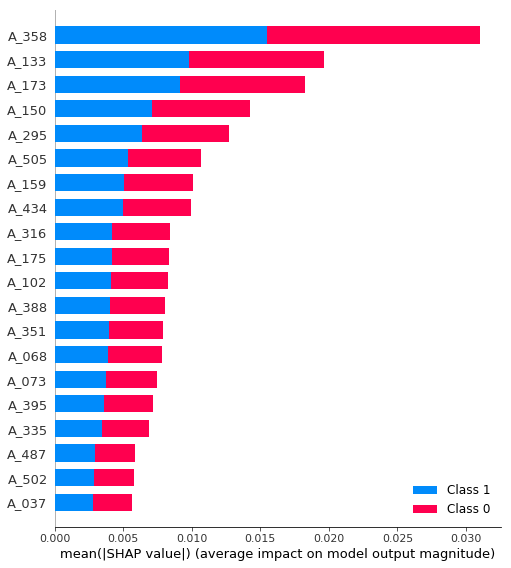

In [125]:
shap.summary_plot(shap_values_test, X_test)

**Задание 7** (0.5 балл)
    Сравните модели из заданий 3,4,5

Лучшее сего себя показал RandomForestб cv_score 

In [127]:
print("KNN: ", cvs(KNeighborsClassifier(n_neighbors=19), X.iloc[:, f_features[:200]], y))
print("Decision tree: ", cvs(DecisionTreeClassifier(max_depth=4), X.iloc[:, f_features[:80]], y))
print("Random forest: ", cvs(RandomForestClassifier(n_estimators=150), X.iloc[:, f_features[:100]], y))

KNN:  0.7224110680822455
Decision tree:  0.6029409152175835
Random forest:  0.7460355981562686


**Задание 8** (2 балл)
    Постройте линейный ансамбль из лучших моделей.

In [129]:
from sklearn.ensemble import StackingClassifier

multi_layer_regressor = StackingClassifier(
    estimators=[('knn', KNeighborsClassifier(n_neighbors=19)),
                ('tree', DecisionTreeClassifier(max_depth=4)),
                ('forest', RandomForestClassifier(n_estimators=150))],
    final_estimator=LogisticRegression()
)
multi_layer_regressor.fit(X_train, y_train)

StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=19)),
                               ('tree', DecisionTreeClassifier(max_depth=4)),
                               ('forest',
                                RandomForestClassifier(n_estimators=150))],
                   final_estimator=LogisticRegression())

In [130]:
cvs(multi_layer_regressor, X_test, y_test)

0.6790038567202028

**Задание 9** (2 балл)
    Постройте ансамбль из лучших моделей при помощи какой-либо реализации GBDT, например -- lightgbm или catboost

In [140]:
from catboost import CatBoostClassifier, metrics

model = CatBoostClassifier(
    custom_loss=[metrics.AUC()],
    random_seed=42,
    logging_level='Silent'
)

In [141]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=42)

In [143]:
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val),
          logging_level='', plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [144]:
model.best_score_

{'learn': {'Logloss': 0.023917668321793942},
 'validation': {'Logloss': 0.6151874670432109, 'AUC': 0.7254401573328338}}

**Задание 10** (0.5 балл)
    Сделайте вывод, помогло ли ансамблирование победить лучшие модели. В чем могут быть причины?

Ансамблирование не помогло победить лучшие модели - random forest оказался сильнее. 